In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor *=255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0]==0
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = '/content/stata.jpg'
style_path = '/content/20.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = PIL.Image.open(path_to_img)
  leng = max(img.size)
  scale = max_dim/leng
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)

  img = tf.keras.preprocessing.image.img_to_array(img)

  #we need to bradcast the image array such that it has a batch dimension
  img = np.expand_dims(img, axis=0)

  return img


In [ ]:
def display_img(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

<ipython-input-144-e4a816a47b1e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)


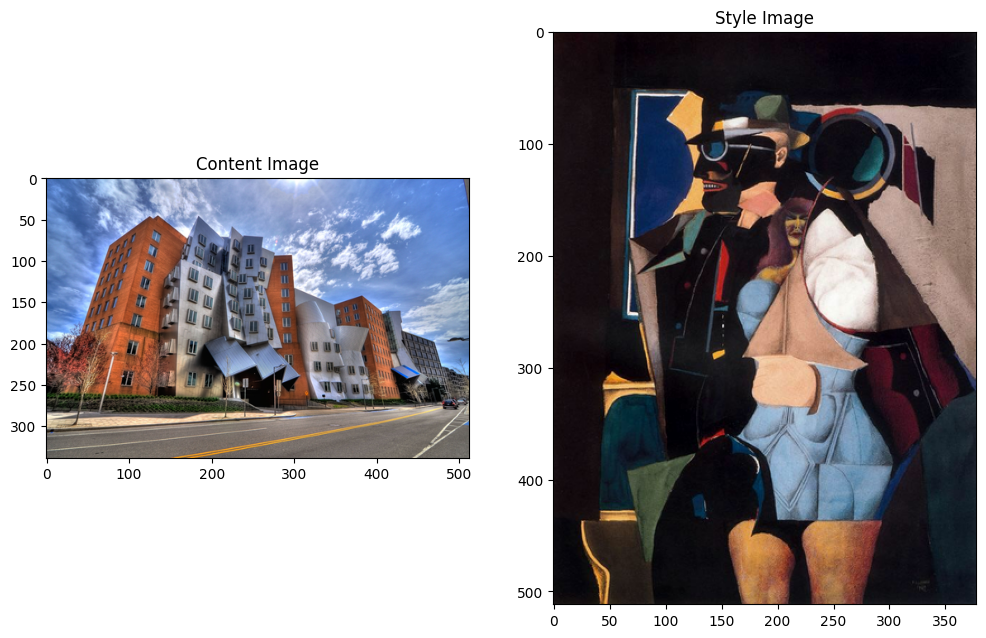

In [ ]:
#let us view our content and style image
content_img = load_img(content_path)
style_img = load_img(style_path)

plt.subplot(1,2,1)
display_img(content_img,'Content Image')

plt.subplot(1,2,2)
display_img(style_img,'Style Image')

plt.show()

In [ ]:
def load_preprocess_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x,0)
  assert len(x.shape) == 3, "Input dimensiion must ne 4 or 3"

  x[: ,:, 0] += 103.939
  x[:, :, 1] += 116.779
  x[: ,:, 2] += 123.68

  x = np.clip(x,0,255).astype('uint8')

  return x

# def reprocess(img):
  # img[: , : , ]

VGG 19 Model Layers

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

input_19
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choosing Layers for content feature extraction and style features extraction from the VGG19 model  

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Model Based on Pretrained VGG19

In [ ]:
def get_model():
  "Create a model to access intermediate layers"
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  style_output = [vgg.get_layer(name).output for name in style_layers]
  content_output = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_output+content_output
  return tf.keras.Model(vgg.input, model_outputs)

Total Loss = Content Loss + Style Loss

In [ ]:
# Calculating the Content loss
def content_loss(base_img, content_img):
  return tf.reduce_mean((base_img-content_img)**2)

In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor,[-1,channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a, transpose_a=True)
  return gram/tf.cast(n,tf.float32)

In [ ]:
# Calculating the Style loss
def style_loss(base_img, style_img):
  height, width, channels = base_img.get_shape().as_list()
  gram_style = gram_matrix(base_img)

  return tf.reduce_mean((gram_style-style_img)**2)

Running The Model

In [ ]:
def preprocess(model, content_path, style_path):
  content_img = load_preprocess_img(content_path)
  style_img = load_preprocess_img(style_path)

  #now we will fetch the features of the content and style image by passing it to the model
  content_output = model(content_img)
  style_output = model(style_img)

  #getting the desrired features according to the layers mentioned above
  style_features = [style_layer[0] for style_layer in style_output[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_output[num_style_layers:]]

  return style_features, content_features

Total Loss Function

In [ ]:
def compute_loss(model, loss_weights, base_img, gram_style, content_features):
  style_weight, content_weight = loss_weights

  model_outputs = model(base_img)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  #finding loss on the style layer. We will gove equal weightage to each layer
  weight_per_style_layer = 1.0/float(num_style_layers)
  for target_style, style in zip(gram_style, style_output_features):
    style_score += weight_per_style_layer*style_loss(style[0], target_style)

  #finding loss on the content layer. We will give equal weights to each layer
  weight_per_content_layer = 1.0/float(num_content_layers)
  for target_content, content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer*content_loss(content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  #final loss
  loss = style_score+content_score

  return loss, style_score, content_score


In [ ]:
def compute_gradient(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  total_loss = all_loss[0]    #loss wrt input image
  return tape.gradient(total_loss, cfg['base_img']), all_loss

Optimizing Using Adamax Optimizer

In [ ]:
import IPython.display

def art_generation(content_path, style_path, num_iterations=200, content_weight=1e3, style_weight=1e-1):
  #calling the model
  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  style_features, content_features = preprocess(model, content_path, style_path)
  gram_style = [gram_matrix(style_feature) for style_feature in style_features]

  #initializing the base image
  base_img = load_preprocess_img(content_path)
  base_img = tf.Variable(base_img, dtype=np.float32)

  #ooptimizer
  opt = tf.optimizers.Adamax(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  iter_count=1

  best_loss, best_img = float('inf'), None

  loss_weights = (content_weight, style_weight)

  cfg = {'model':model, 'loss_weights':loss_weights, 'base_img':base_img, 'gram_style':gram_style, 'content_features': content_features}

  #for diaplaying the output
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_mean = np.array([130.989, 116.779, 123.68])      #normalization mean for vgg19
  min_val = -norm_mean
  max_val = 255-norm_mean

  imgs = []     #a list to store all the images generated
  for i in range(num_iterations):
    grads, all_loss = compute_gradient(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, base_img)])
    clipped = tf.clip_by_value(base_img, min_val, max_val)
    base_img.assign(clipped)
    end_time = time.time()

    if loss<best_loss:
      best_loss = loss
      best_img = deprocess(base_img.numpy())

    if i%display_interval==0:
      start_time = time.time()

      plot_img = base_img.numpy()
      plot_img = deprocess(base_img.numpy())
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(PIL.Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path)
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  display_img(content, 'Content Image')

  plt.subplot(1, 2, 2)
  display_img(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

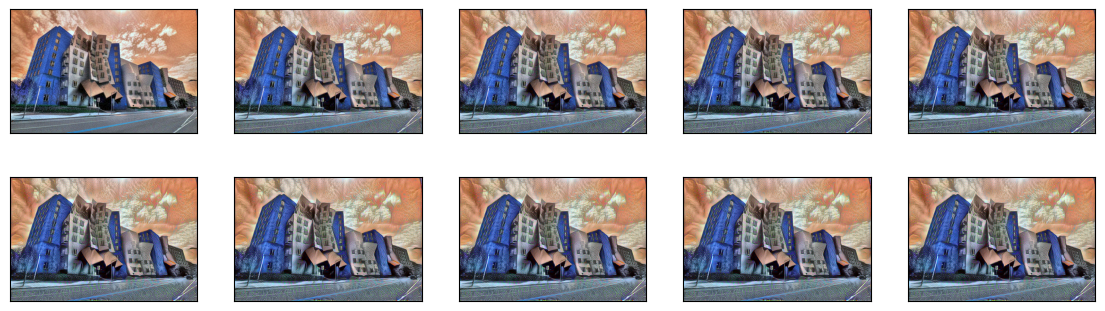

In [ ]:
best, best_loss = art_generation(content_path, style_path, num_iterations=100)

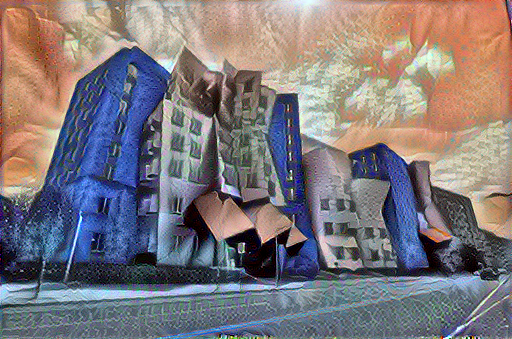

In [ ]:
PIL.Image.fromarray(best)

<ipython-input-144-e4a816a47b1e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)


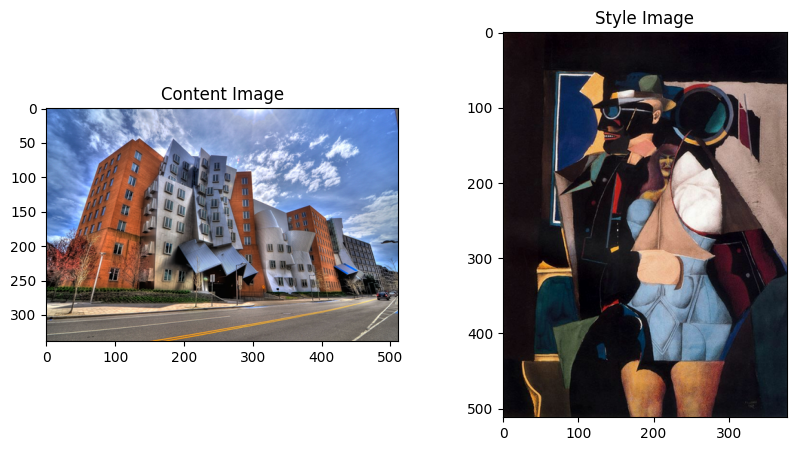

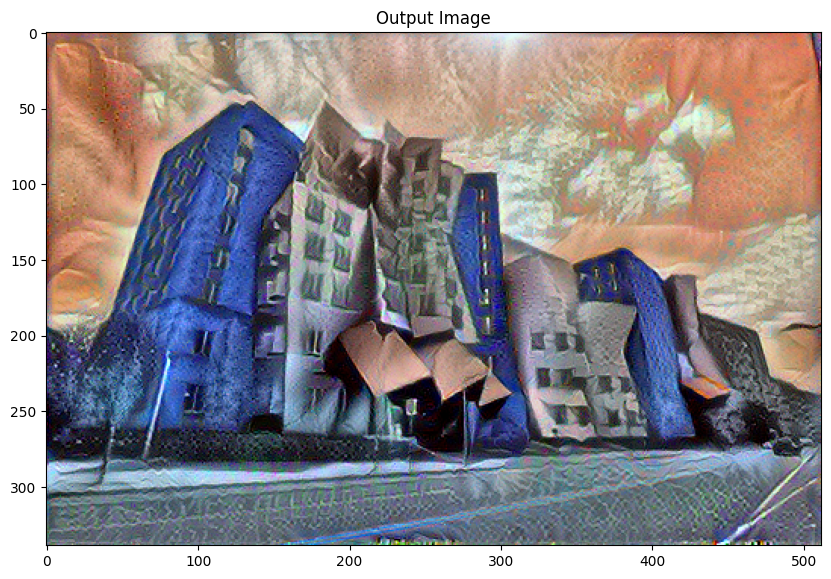

In [ ]:
show_results(best, content_path, style_path)